In [20]:
!nvidia-smi

Fri Nov 15 16:31:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.06             Driver Version: 535.183.06   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA H100 PCIe               On  | 00000000:B5:00.0 Off |                    0 |
| N/A   35C    P0              50W / 350W |      3MiB / 81559MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

# Filtered Data Creation

Filters such as CLAHE (Contrast Limited Adaptive Histogram Equalization), Gaussian Blur, and Canny edge detection are applied to preprocess the Diabetic, Skin Cancer, and Kidney datasets to enhance critical features in the images. CLAHE improves local contrast by redistributing pixel intensities, making subtle features in Diabetic images more prominent. Gaussian Blur reduces noise and smooths the image, creating a cleaner input for models. Canny edge detection highlights sharp boundaries and structures, emphasizing key edges and contours in Kidney images. These preprocessing techniques aim to make meaningful patterns more distinguishable, ultimately helping the model focus on essential features and improving accuracy in downstream tasks.

In [3]:
import os
import cv2
import numpy as np
from PIL import Image
from torchvision.transforms.functional import adjust_contrast, adjust_sharpness
from torchvision.transforms import Resize, Lambda
from tqdm import tqdm

In [4]:
def apply_filter_and_save(input_dir, output_dir, dataset_type, preprocess_fn):
    '''
    Recursively processes images from the input directory by applying a given preprocessing function, 
    then saves them with the appropriate format in the output directory.
    '''
    if not os.path.exists(output_dir):
        os.makedirs(output_dir, exist_ok=True)

    for root, dirs, files in os.walk(input_dir):
        rel_path = os.path.relpath(root, input_dir)
        target_dir = os.path.join(output_dir, rel_path)
        if not os.path.exists(target_dir):
            os.makedirs(target_dir, exist_ok=True)
        for file in tqdm(files, desc=f"Processing {dataset_type} - {rel_path}"):
            file_ext = os.path.splitext(file)[1].lower()  # Get the file extension
            if file_ext in ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff', '.webp'):
                input_file_path = os.path.join(root, file)
                output_file_path = os.path.join(target_dir, file)
                img = Image.open(input_file_path).convert("RGB")
                processed_img = preprocess_fn(img)

                if file_ext == '.jpg' or file_ext == '.jpeg':
                    processed_img.save(output_file_path, format='JPEG')
                elif file_ext == '.png':
                    processed_img.save(output_file_path, format='PNG')
                elif file_ext == '.bmp':
                    processed_img.save(output_file_path, format='BMP')
                elif file_ext == '.tif' or file_ext == '.tiff':
                    processed_img.save(output_file_path, format='TIFF')
                elif file_ext == '.webp':
                    processed_img.save(output_file_path, format='WEBP')
                else:
                    output_file_path = os.path.splitext(output_file_path)[0] + ".png"
                    processed_img.save(output_file_path, format='PNG')



In [5]:
def preprocess_diabetic(img):
    '''
    Converts the image to grayscale, enhances its contrast using CLAHE, and then converts it back to RGB.
    '''
    img_np = np.array(img)
    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)
    return Image.fromarray(cv2.cvtColor(enhanced, cv2.COLOR_GRAY2RGB))

def preprocess_skin(img):
    '''
    Increases sharpness and contrast to highlight details in skin images.
    '''
    img = adjust_sharpness(img, sharpness_factor=2.0) 
    img = adjust_contrast(img, contrast_factor=1.5)  
    return img

def preprocess_kidney(img):
    '''
    Applies a Gaussian blur and edge detection (Canny) to highlight kidney structures, then returns as an RGB image.
    '''
    img_np = np.array(img)
    blurred = cv2.GaussianBlur(img_np, (5, 5), 0)
    edges = cv2.Canny(blurred, threshold1=50, threshold2=150)
    edges_rgb = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)
    return Image.fromarray(edges_rgb)

In [6]:
TARGET_DIR = "/projects/academic/shamsadp/"
input_dirs = {
    "diabetic": os.path.join(TARGET_DIR, "medxformer/diabetic"),
    "skin": os.path.join(TARGET_DIR, "medxformer/skin"),
    "kidney": os.path.join(TARGET_DIR, "medxformer/kidney"),
}
output_dirs = {
    "diabetic": os.path.join(TARGET_DIR, "medxformer/diabetic_filtered"),
    "skin": os.path.join(TARGET_DIR, "medxformer/skin_filtered"),
    "kidney": os.path.join(TARGET_DIR, "medxformer/kidney_filtered"),
}

In [7]:
apply_filter_and_save(input_dirs["diabetic"], output_dirs["diabetic"], "diabetic", preprocess_diabetic)
apply_filter_and_save(input_dirs["skin"], output_dirs["skin"], "skin", preprocess_skin)
apply_filter_and_save(input_dirs["kidney"], output_dirs["kidney"], "kidney", preprocess_kidney)

print("Filtered images saved successfully!")

Processing diabetic - .: 0it [00:00, ?it/s]
Processing diabetic - diabetic_mild_retinopathy: 100%|██████████| 2000/2000 [06:31<00:00,  5.11it/s]
Processing diabetic - diabetic_moderate_retinopathy: 100%|██████████| 2000/2000 [18:19<00:00,  1.82it/s]
Processing diabetic - diabetic_no_retinopathy: 100%|██████████| 2000/2000 [13:29<00:00,  2.47it/s]
Processing diabetic - diabetic_proliferative_retinopathy: 100%|██████████| 2000/2000 [06:09<00:00,  5.42it/s]
Processing diabetic - diabetic_severe_retinopathy: 100%|██████████| 2000/2000 [03:58<00:00,  8.38it/s]
Processing skin - .: 0it [00:00, ?it/s]
Processing skin - skin_nevus: 100%|██████████| 2000/2000 [00:33<00:00, 59.16it/s] 
Processing skin - skin_pigmented_benign_keratosis: 100%|██████████| 2000/2000 [00:17<00:00, 112.49it/s]
Processing skin - skin_vascular_lesion: 100%|██████████| 2000/2000 [00:15<00:00, 133.29it/s]
Processing kidney - .: 0it [00:00, ?it/s]
Processing kidney - kidney_tumor: 100%|██████████| 1500/1500 [00:16<00:00, 8

Filtered images saved successfully!


# Low Rank Adaptation Training on Data modified with filters


### **1. Diabetic Dataset**
- **Grayscale Conversion**: Converts the image to grayscale using `cv2.cvtColor`.
- **CLAHE (Contrast Limited Adaptive Histogram Equalization)**: Enhances local contrast by applying CLAHE to the grayscale image, which is particularly useful for improving visibility of features in medical images.

### **2. Skin Dataset**
- **Sharpness Adjustment**: Sharpness of the image is increased using `adjust_sharpness` with a factor of **2.0** to enhance fine details in the images.
- **Contrast Adjustment**: Contrast of the image is increased using `adjust_contrast` with a factor of **1.5** to make features stand out more distinctly.

### **3. Kidney Dataset**
- **Gaussian Blur**: A Gaussian blur is applied to the image to reduce noise and detail, smoothing the image.
- **Canny Edge Detection**: After blurring, edge detection is performed using the Canny edge detection algorithm, which highlights the edges and boundaries in the image.
- **Edge Conversion to RGB**: The resulting edges are converted back to RGB format for consistent output.

These preprocessing filters are tailored to enhance the features specific to the characteristics of each dataset, potentially improving the effectiveness of downstream tasks like classification or segmentation.

In [8]:
import os 
import torch
import evaluate
import numpy as np
import pandas as pd
from PIL import Image
from torch import optim
from copy import deepcopy
from tabulate import tabulate
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from torchvision import transforms
from transformers import get_scheduler
from transformers import TrainingArguments
from torch.utils.data import Dataset, DataLoader, Subset
from peft import (
    PeftModel, 
    LoraConfig, 
    get_peft_model, 
    AdaLoraConfig,
    IA3Config,
    LoHaConfig,
    LoKrConfig,
)
from transformers import (
    AutoModelForImageClassification,
    AutoImageProcessor,
    TrainingArguments,
    Trainer,
    TrainerCallback
)
from torchvision.transforms import (
    Compose, 
    Normalize, 
    Resize, 
    ToTensor
)


2024-11-23 20:58:13.109749: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-23 20:58:19.216546: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [9]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [11]:
def print_model_size(path):
    '''
    Calculates and prints the combined size of all files in the specified directory, in megabytes.
    '''
    size = 0
    for f in os.scandir(path):
        size += os.path.getsize(f)
    print(f"Model size: {(size / 1e6):.2} MB")

def print_trainable_parameters(model, label):
    '''
    Counts the total parameters and the trainable parameters in the given model,
    then prints the count and percentage of trainable parameters.
    '''
    parameters, trainable = 0, 0    
    for _, p in model.named_parameters():
        parameters += p.numel()
        trainable += p.numel() if p.requires_grad else 0
    print(f"{label} trainable parameters: {trainable:,}/{parameters:,} ({100 * trainable / parameters:.2f}%)")
    
def create_label_mappings(dataset):
    '''
    Extracts unique labels from a dataset and returns two dictionaries:
    one mapping labels to IDs and another mapping IDs back to labels.
    '''
    label2id, id2label = dict(), dict()
    unique_labels = set([label for _, label in dataset.samples]) 
    for i, label in enumerate(unique_labels):
        label2id[label] = i
        id2label[i] = label
    return label2id, id2label

In [12]:
class CustomDataset(Dataset):
    '''
    A custom dataset that randomly selects a fraction of images from each subdirectory,
    applies optional transformations, and returns them with a numeric label ID.
    '''
    def __init__(self, root_dir, transform=None, load_fraction=0.1):
        self.transform = transform
        self.samples = []
        self.label2id = {}
        class_id = 0
        for class_dir in os.listdir(root_dir):
            self.label2id[class_dir] = class_id
            class_id += 1
            class_path = os.path.join(root_dir, class_dir)
            all_files = os.listdir(class_path)
            sample_count = int(len(all_files) * load_fraction)
            chosen_files = np.random.choice(all_files, sample_count, replace=False)
            for filename in chosen_files:
                self.samples.append((os.path.join(class_path, filename), class_dir))

    def __len__(self):
        '''Returns the total number of selected samples.'''
        return len(self.samples)

    def __getitem__(self, idx):
        '''Loads the image at the specified index, applies transforms, and returns it with its label ID.'''
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            processed = self.transform(image)
            image = processed['pixel_values'][0]  
        return image, self.label2id[label]

    def set_transform(self, transform):
        '''Updates the dataset's transform.'''
        self.transform = transform

    def get_image_path(self, idx):
        '''Returns the original file path of the image at the given index.'''
        img_path, _ = self.samples[idx] 
        return img_path

def split_dataset(dataset, test_size=0.1, shuffle=True):
    '''
    Splits the dataset into training and testing subsets based on the given test size ratio.
    '''
    indices = list(range(len(dataset)))
    train_indices, test_indices = train_test_split(indices, test_size=test_size, shuffle=shuffle)

    train_dataset = torch.utils.data.Subset(dataset, train_indices)
    test_dataset = torch.utils.data.Subset(dataset, test_indices)

    return train_dataset, test_dataset

transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor()
])


In [13]:
model_checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(model_checkpoint)

preprocess_pipeline = Compose([
    lambda image: {
        'pixel_values': torch.tensor(image_processor(image.convert("RGB")).pixel_values)
    }
])

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [14]:
base_dir = '/projects/academic/shamsadp/medxformer'
disease_dirs = {
    "diabetic": os.path.join(base_dir, "diabetic_filtered"),
    "skin": os.path.join(base_dir, "skin_filtered"),
    "kidney": os.path.join(base_dir, "kidney_filtered")
}

allowed_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')

def count_images_in_classes(disease_dir):
    '''
    Counts and prints the number of images in each class directory under a given disease directory.
    '''
    for class_name in os.listdir(disease_dir):
        class_path = os.path.join(disease_dir, class_name)
        if os.path.isdir(class_path):
            image_count = sum(
                1 for file in os.listdir(class_path) if file.lower().endswith(allowed_extensions)
            )
            print(f"Class '{class_name}' has {image_count} images.")

for disease, disease_path in disease_dirs.items():
    if os.path.exists(disease_path):
        print(f"\nCounting images in {disease} dataset...")
        count_images_in_classes(disease_path)
    else:
        print(f"[ERROR] Disease directory '{disease}' does not exist at path '{disease_path}'.")


Counting images in diabetic dataset...
Class 'diabetic_mild_retinopathy' has 2000 images.
Class 'diabetic_moderate_retinopathy' has 2000 images.
Class 'diabetic_no_retinopathy' has 2000 images.
Class 'diabetic_proliferative_retinopathy' has 2000 images.
Class 'diabetic_severe_retinopathy' has 2000 images.

Counting images in skin dataset...
Class 'skin_actinic_keratosis' has 2000 images.
Class 'skin_basal_cell_carcinoma' has 2000 images.
Class 'skin_dermatofibroma' has 2000 images.
Class 'skin_melanoma' has 2000 images.
Class 'skin_nevus' has 2000 images.
Class 'skin_pigmented_benign_keratosis' has 2000 images.
Class 'skin_seborrheic_keratosis' has 2000 images.
Class 'skin_squamous_cell_carcinoma' has 2000 images.
Class 'skin_vascular_lesion' has 2000 images.

Counting images in kidney dataset...
Class 'kidney_cyst' has 1500 images.
Class 'kidney_normal' has 1500 images.
Class 'kidney_stone' has 1377 images.
Class 'kidney_tumor' has 1500 images.


In [16]:
base_dir = '/projects/academic/shamsadp/medxformer/'

diabetic_dataset = CustomDataset(f'{base_dir}diabetic_filtered', transform=preprocess_pipeline, load_fraction=1)
skin_cancer_dataset = CustomDataset(f'{base_dir}skin_filtered', transform=preprocess_pipeline, load_fraction=1)
kidney_dataset = CustomDataset(f'{base_dir}kidney_filtered', transform=preprocess_pipeline, load_fraction=1)

diabetic_train_dataset, diabetic_test_dataset = split_dataset(diabetic_dataset, test_size=0.2)
skin_train_dataset, skin_test_dataset = split_dataset(skin_cancer_dataset, test_size=0.2)
kidney_train_dataset, kidney_test_dataset = split_dataset(kidney_dataset, test_size=0.2)

print("Datasets are successfully loaded and split into training and testing sets.")

Datasets are successfully loaded and split into training and testing sets.


In [17]:
def print_batch_shapes(dataset):
    '''
    Prints the shape of the first image and its label in the given dataset,
    as well as the total number of samples in that dataset.
    '''
    image, label = dataset[0]  
    print("Image shape: ", image.shape) 
    print("Label: ", label) 
    print("Dataset size: ", len(dataset))  

print("\nShapes for Diabetic Dataset Train Loader:")
print_batch_shapes(diabetic_train_dataset)
print("\nShapes for Diabetic Dataset Test Loader:")
print_batch_shapes(diabetic_test_dataset)

print("\nShapes for Skin Cancer Dataset Train Loader:")
print_batch_shapes(skin_train_dataset)
print("\nShapes for Skin Cancer Dataset Test Loader:")
print_batch_shapes(skin_test_dataset)

print("\nShapes for Kidney Dataset Train Loader:")
print_batch_shapes(kidney_train_dataset)
print("\nShapes for Kidney Dataset Test Loader:")
print_batch_shapes(kidney_test_dataset)



Shapes for Diabetic Dataset Train Loader:
Image shape:  torch.Size([3, 224, 224])
Label:  0
Dataset size:  8000

Shapes for Diabetic Dataset Test Loader:
Image shape:  torch.Size([3, 224, 224])
Label:  4
Dataset size:  2000

Shapes for Skin Cancer Dataset Train Loader:
Image shape:  torch.Size([3, 224, 224])
Label:  2
Dataset size:  14400

Shapes for Skin Cancer Dataset Test Loader:
Image shape:  torch.Size([3, 224, 224])
Label:  2
Dataset size:  3600

Shapes for Kidney Dataset Train Loader:
Image shape:  torch.Size([3, 224, 224])
Label:  1
Dataset size:  4701

Shapes for Kidney Dataset Test Loader:
Image shape:  torch.Size([3, 224, 224])
Label:  2
Dataset size:  1176


In [18]:
diabetic_dataset_id2label = {v: k for k, v in diabetic_dataset.label2id.items()}
diabetic_dataset_label2id = diabetic_dataset.label2id

skin_cancer_dataset_id2label = {v: k for k, v in skin_cancer_dataset.label2id.items()}
skin_cancer_dataset_label2id = skin_cancer_dataset.label2id

kidney_dataset_id2label = {v: k for k, v in kidney_dataset.label2id.items()}
kidney_dataset_label2id = kidney_dataset.label2id

print("Diabetic Dataset Label to ID Mapping:", diabetic_dataset_id2label)
print("\nSkin Cancer Dataset Label to ID Mapping:", skin_cancer_dataset_id2label)
print("\nKidney Dataset Label to ID Mapping:", kidney_dataset_id2label)

Diabetic Dataset Label to ID Mapping: {0: 'diabetic_mild_retinopathy', 1: 'diabetic_moderate_retinopathy', 2: 'diabetic_no_retinopathy', 3: 'diabetic_proliferative_retinopathy', 4: 'diabetic_severe_retinopathy'}

Skin Cancer Dataset Label to ID Mapping: {0: 'skin_actinic_keratosis', 1: 'skin_basal_cell_carcinoma', 2: 'skin_dermatofibroma', 3: 'skin_melanoma', 4: 'skin_nevus', 5: 'skin_pigmented_benign_keratosis', 6: 'skin_seborrheic_keratosis', 7: 'skin_squamous_cell_carcinoma', 8: 'skin_vascular_lesion'}

Kidney Dataset Label to ID Mapping: {0: 'kidney_cyst', 1: 'kidney_normal', 2: 'kidney_stone', 3: 'kidney_tumor'}


In [19]:
def check_unique_labels(dataset, id2label, batch_size=64):
    '''
    Checks and prints all unique labels present in the given dataset. It does so by
    iterating through a DataLoader until it has encountered all labels in id2label.
    '''
    unique_labels = set()
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    for batch in dataloader:
        _, labels = batch
        unique_labels.update(labels.tolist())

        if len(unique_labels) == len(id2label):
            break
    print("Unique labels in the dataset:")
    for label in unique_labels:
        print(f"Label {label}: {id2label.get(label, 'Unknown label')}")


print("\nUnique labels in diabetic_train_dataset:")
check_unique_labels(diabetic_train_dataset, diabetic_dataset_id2label)

print("\nUnique labels in diabetic_test_dataset:")
check_unique_labels(diabetic_test_dataset, diabetic_dataset_id2label)

print("\nUnique labels in skin_cancer_train_dataset:")
check_unique_labels(skin_train_dataset, skin_cancer_dataset_id2label)

print("\nUnique labels in skin_cancer_test_dataset:")
check_unique_labels(skin_test_dataset, skin_cancer_dataset_id2label)

print("\nUnique labels in kidney_train_dataset:")
check_unique_labels(kidney_train_dataset, kidney_dataset_id2label)

print("\nUnique labels in kidney_test_dataset:")
check_unique_labels(kidney_test_dataset, kidney_dataset_id2label)



Unique labels in diabetic_train_dataset:
Unique labels in the dataset:
Label 0: diabetic_mild_retinopathy
Label 1: diabetic_moderate_retinopathy
Label 2: diabetic_no_retinopathy
Label 3: diabetic_proliferative_retinopathy
Label 4: diabetic_severe_retinopathy

Unique labels in diabetic_test_dataset:
Unique labels in the dataset:
Label 0: diabetic_mild_retinopathy
Label 1: diabetic_moderate_retinopathy
Label 2: diabetic_no_retinopathy
Label 3: diabetic_proliferative_retinopathy
Label 4: diabetic_severe_retinopathy

Unique labels in skin_cancer_train_dataset:
Unique labels in the dataset:
Label 0: skin_actinic_keratosis
Label 1: skin_basal_cell_carcinoma
Label 2: skin_dermatofibroma
Label 3: skin_melanoma
Label 4: skin_nevus
Label 5: skin_pigmented_benign_keratosis
Label 6: skin_seborrheic_keratosis
Label 7: skin_squamous_cell_carcinoma
Label 8: skin_vascular_lesion

Unique labels in skin_cancer_test_dataset:
Unique labels in the dataset:
Label 0: skin_actinic_keratosis
Label 1: skin_bas

In [22]:
config_medX = {
    "DIABETIC_ADAPTER_MODEL": {
        "train_data": diabetic_train_dataset,
        "test_data": diabetic_test_dataset,
        "label2id": diabetic_dataset_label2id,
        "id2label": diabetic_dataset_id2label,
        "epochs": 15,
        "path": "./lora-diabetic-model"
    },
    
    "SKIN_CANCER_ADAPTER_MODEL": {
        "train_data": skin_train_dataset,
        "test_data": skin_test_dataset,
        "label2id": skin_cancer_dataset_label2id,
        "id2label": skin_cancer_dataset_id2label,
        "epochs": 15,
        "path": "./lora-skin_cancer-model"
    },

    "KIDNEY_ADAPTER_MODEL": {
        "train_data": kidney_train_dataset,
        "test_data": kidney_test_dataset,
        "label2id": kidney_dataset_label2id,
        "id2label": kidney_dataset_id2label,
        "epochs": 15,
        "path": "./lora-kidney-model"
    },
}


In [23]:
adapter_configs = {
    "lora": {
        "peft_type": "LORA",
        "config": LoraConfig(
            task_type="IMAGE_CLASSIFICATION",
            r=4,  
            lora_alpha=32,  
            target_modules=["query", "value", "key"],  
            lora_dropout=0.2,  
            bias="none",
            modules_to_save=["classifier"],
        )
    },

    "adalora": {
        "peft_type": "ADALORA",
        "config": AdaLoraConfig(
            task_type="IMAGE_CLASSIFICATION",
            init_r=8,  
            lora_alpha=32,  
            target_modules=["query", "value", "key"],  
            lora_dropout=0.05,
            modules_to_save=["classifier"],
        )
    },

    "ia3": {
        "peft_type": "IA3",
        "config": IA3Config(
            task_type="IMAGE_CLASSIFICATION",
            target_modules=["query", "value", "key", "output.dense", "intermediate.dense"],  
            feedforward_modules=["output.dense", "intermediate.dense"],
            modules_to_save=["classifier"],
        )
    },

    "loha": {
        "peft_type": "LOHA",
        "config": LoHaConfig(
            task_type="IMAGE_CLASSIFICATION",
            r=8,  
            alpha=32,  
            target_modules=["query", "value", "key"],  
            modules_to_save=["classifier"],
        )
    },

    "lokr": {
        "peft_type": "LOKR",
        "config": LoKrConfig(
            task_type="IMAGE_CLASSIFICATION",
            r=8,  
            alpha=32,  
            target_modules=["query", "value", "key"], 
            modules_to_save=["classifier"],
        )
    }
}

In [24]:
metric = evaluate.load("accuracy")
metric_accuracy = evaluate.load("accuracy")
metric_f1 = evaluate.load("f1")
metric_precision = evaluate.load("precision")
metric_recall = evaluate.load("recall")

def data_collate(examples):
    '''
    Batches a list of (image, label) pairs into a dictionary of pixel_values and labels tensors.
    '''
    pixel_values = torch.stack([example[0] for example in examples])
    labels = torch.tensor([example[1] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

def compute_metrics(eval_pred):
    '''
    Computes accuracy, F1, precision, and recall from the model's predictions.
    '''
    predictions = np.argmax(eval_pred.predictions, axis=1)
    accuracy = metric_accuracy.compute(predictions=predictions, references=eval_pred.label_ids)["accuracy"]
    f1 = metric_f1.compute(predictions=predictions, references=eval_pred.label_ids, average="weighted")["f1"]
    precision = metric_precision.compute(predictions=predictions, references=eval_pred.label_ids, average="weighted")["precision"]
    recall = metric_recall.compute(predictions=predictions, references=eval_pred.label_ids, average="weighted")["recall"]
    return {"accuracy": accuracy, "f1": f1, "precision": precision, "recall": recall}

metrics_storage = {
    adapter_type: {
        lora_type: {
            "train_accuracy": [],  
            "eval_accuracy": [],   
            "train_loss": [],      
            "eval_loss": [],       
            "eval_f1": [],         
            "eval_precision": [],  
            "eval_recall": []      
        }
        for lora_type in adapter_configs.keys()
    }
    for adapter_type in config_medX.keys()  
}

def get_base_model(label2id, id2label):
    '''
    Loads a pre-trained image classification model with the given label mappings.
    '''
    return AutoModelForImageClassification.from_pretrained(
        model_checkpoint, label2id=label2id, id2label=id2label, ignore_mismatched_sizes=True).to(device)


In [26]:
batch_size = 128

In [27]:
def get_training_arguments(epochs):
    '''
    Returns a set of training arguments configured for saving model checkpoints,
    evaluating after each epoch, and using a specific learning rate, batch size, 
    and other parameters for the given number of epochs.
    '''
    return TrainingArguments(
        output_dir="./model-checkpoints",
        weight_decay=0.01,
        remove_unused_columns=False,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        logging_strategy="epoch",
        learning_rate=5e-3,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        gradient_accumulation_steps=4,
        fp16=True,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        label_names=["labels"],
        num_train_epochs=epochs,  
        save_total_limit=2,
        logging_dir='./logs',
        disable_tqdm=True  
    )

In [28]:
class LoggingCallback(TrainerCallback):
    '''
    A custom callback to track and report training progress, including logging metrics and plotting them at the end.
    '''
    def __init__(self, adapter_type, lora_type, model, train_dataloader):
        self.adapter_type = adapter_type
        self.lora_type = lora_type
        self.model_name = f"{adapter_type}_{lora_type}"
        self.model = model
        self.train_dataloader = train_dataloader
        self.current_epoch = 1 
        
    def on_epoch_begin(self, args, state, control, **kwargs):
        '''Prints a message at the start of each epoch.'''
        print(f"Starting Epoch {self.current_epoch}")

    def on_log(self, args, state, control, logs=None, **kwargs):
        '''Logs training/evaluation metrics as they become available.'''
        if logs:
            metrics = metrics_storage[self.adapter_type][self.lora_type]
            if "eval_loss" in logs:
                metrics["eval_loss"].append(logs["eval_loss"])
                metrics["eval_accuracy"].append(logs.get("eval_accuracy", 0))
                metrics["eval_f1"].append(logs.get("eval_f1", 0))
                metrics["eval_precision"].append(logs.get("eval_precision", 0))
                metrics["eval_recall"].append(logs.get("eval_recall", 0))
            if "loss" in logs:
                metrics["train_loss"].append(logs["loss"])

    def on_epoch_end(self, args, state, control, **kwargs):
        '''At the end of each epoch, compute and store training accuracy.'''
        print(f"Epoch {self.current_epoch} ending")
        train_accuracy = self.compute_train_accuracy()
        metrics_storage[self.adapter_type][self.lora_type]["train_accuracy"].append(train_accuracy)
        
        print(f"Completed Epoch {self.current_epoch}")
        self.current_epoch += 1

    def compute_train_accuracy(self):
        '''
        Computes accuracy on the entire training set for the current model
        state to provide additional insights beyond evaluation metrics.
        '''
        train_dataloader = DataLoader(
            config_medX[self.adapter_type]["train_data"],
            batch_size=batch_size,
            collate_fn=data_collate
        )
        correct = 0
        total = 0
        self.model.eval()
        with torch.no_grad():
            for batch in train_dataloader:
                pixel_values = batch["pixel_values"].to(device)
                labels = batch["labels"].to(device)
                outputs = self.model(pixel_values=pixel_values)
                preds = outputs.logits.argmax(dim=-1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        return correct / total if total > 0 else 0

    def on_train_end(self, args, state, control, **kwargs):
        '''
        After training completes, prints a tabular summary of metrics
        across all epochs, then plots the training and evaluation metrics.
        '''
        print(f"\nTraining completed for {self.model_name}. Final Metrics:")
        metrics = metrics_storage[self.adapter_type][self.lora_type]
        max_length = max(len(metrics[key]) for key in metrics)
        for key in metrics:
            metrics[key].extend([None] * (max_length - len(metrics[key])))
        metrics_data = {
            "Epoch": list(range(1, max_length + 1)),
            "Train Accuracy": metrics["train_accuracy"],
            "Eval Accuracy": metrics["eval_accuracy"],
            "Train Loss": metrics["train_loss"],
            "Eval Loss": metrics["eval_loss"],
            "F1": metrics["eval_f1"],
            "Precision": metrics["eval_precision"],
            "Recall": metrics["eval_recall"]
        }

        metrics_df = pd.DataFrame(metrics_data)
        print(tabulate(metrics_df, headers="keys", tablefmt="grid"))
        self.plot_metrics()

    def plot_metrics(self):
        '''Plots training and evaluation loss and accuracy over epochs.'''
        metrics = metrics_storage[self.adapter_type][self.lora_type]
        train_loss = metrics["train_loss"]
        eval_loss = metrics["eval_loss"]
        eval_accuracy = metrics["eval_accuracy"]
        train_accuracy = metrics["train_accuracy"]
        min_len = min(len(train_loss), len(eval_loss), len(eval_accuracy), len(train_accuracy))
        epochs = list(range(1, min_len + 1))
        train_loss = train_loss[:min_len]
        eval_loss = eval_loss[:min_len]
        eval_accuracy = eval_accuracy[:min_len]
        train_accuracy = train_accuracy[:min_len]

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_loss, label="Train Loss", marker="o")
        plt.plot(epochs, eval_loss, label="Eval Loss", marker="s")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(f"Loss per Epoch for {self.model_name}")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_accuracy, label="Train Accuracy", marker="o")
        plt.plot(epochs, eval_accuracy, label="Eval Accuracy", marker="s")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title(f"Accuracy per Epoch for {self.model_name}")
        plt.legend()
        plt.tight_layout()
        plt.show()


In [29]:
def build_adapter_model(adapter_type, label2id, id2label):
    '''
    Builds an adapter model by loading a base model, applying a PEFT configuration,
    and printing out the number of trainable parameters.
    '''
    base_model = get_base_model(label2id, id2label).to(device)
    config = adapter_configs[adapter_type]["config"]
    adapter_model = get_peft_model(base_model, config).to(device)
    print_trainable_parameters(adapter_model, label=f"{adapter_type} Adapter")
    return adapter_model

def train_model_with_adapter(adapter_type, lora_type):
    '''
    Trains a model for a given adapter and LoRA configuration, evaluates it, and saves the trained model.
    '''
    config_data = config_medX[adapter_type]
    model = build_adapter_model(lora_type, config_data["label2id"], config_data["id2label"])
    optimizer = optim.AdamW(model.parameters(), lr=5e-3, weight_decay=0.01)
    total_train_steps = len(config_data["train_data"]) // batch_size * config_data["epochs"]
    print("Number of Training Epochs: ", config_data["epochs"])
    model_training_args = get_training_arguments(config_data["epochs"])
    scheduler = get_scheduler(
        "linear", optimizer=optimizer, num_warmup_steps=100, num_training_steps=total_train_steps
    )
    train_dataloader = DataLoader(
        config_data["train_data"], batch_size=batch_size
    )
    trainer = Trainer(
        model=model,
        args=model_training_args,
        train_dataset=config_data["train_data"],
        eval_dataset=config_data["test_data"],
        data_collator=data_collate,
        compute_metrics=compute_metrics,
        optimizers=(optimizer, scheduler),
        callbacks=[LoggingCallback(adapter_type, lora_type, model, train_dataloader)]  
    )
    trainer.train()
    metrics = trainer.evaluate()
    save_dir = './medxformer_filtered/'
    os.makedirs(save_dir, exist_ok=True)
    model_path = os.path.join(save_dir, f"{adapter_type}_{lora_type}")
    trainer.save_model(model_path)
    return metrics



Training DIABETIC_ADAPTER_MODEL with lora type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


lora Adapter trainable parameters: 221,184/86,023,685 (0.26%)
Number of Training Epochs:  15
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'loss': 6.6961, 'grad_norm': 0.8594419956207275, 'learning_rate': 0.00075, 'epoch': 0.9523809523809523}
{'eval_loss': 1.5191484689712524, 'eval_accuracy': 0.4615, 'eval_f1': 0.42238055909724315, 'eval_precision': 0.48269775653064506, 'eval_recall': 0.4615, 'eval_runtime': 93.769, 'eval_samples_per_second': 21.329, 'eval_steps_per_second': 0.171, 'epoch': 0.9523809523809523}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'loss': 4.9289, 'grad_norm': 5.442413806915283, 'learning_rate': 0.00155, 'epoch': 1.9682539682539684}
{'eval_loss': 1.0606423616409302, 'eval_accuracy': 0.5905, 'eval_f1': 0.5744366970523488, 'eval_precision': 0.5694503807541546, 'eval_recall': 0.5905, 'eval_runtime': 92.235, 'eval_samples_per_second': 21.684, 'eval_steps_per_second': 0.173, 'epoch': 1.9682539682539684}
Starting Epoch 3
Epoch 3 ending
Completed Epoch 3
{'lo

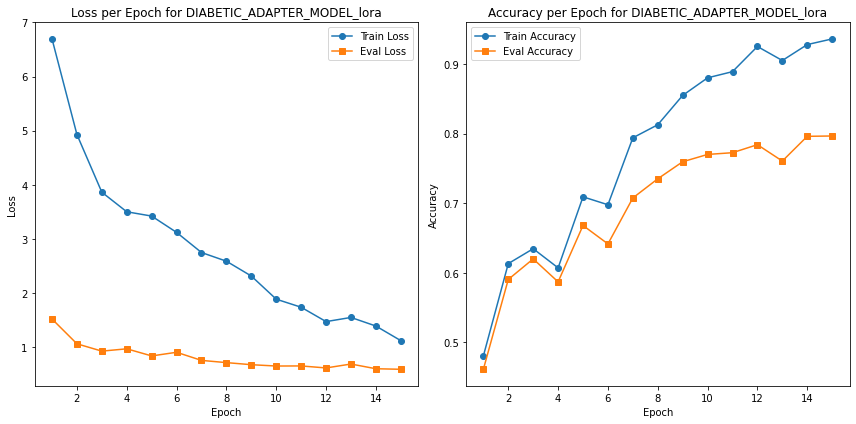

{'eval_loss': 0.5897818803787231, 'eval_accuracy': 0.7965, 'eval_f1': 0.7918130374099982, 'eval_precision': 0.7949439346840133, 'eval_recall': 0.7965, 'eval_runtime': 91.5075, 'eval_samples_per_second': 21.856, 'eval_steps_per_second': 0.175, 'epoch': 14.285714285714286}

Training DIABETIC_ADAPTER_MODEL with adalora type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


adalora Adapter trainable parameters: 442,656/86,245,193 (0.51%)
Number of Training Epochs:  15
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'loss': 6.7834, 'grad_norm': 0.031189776957035065, 'learning_rate': 0.00075, 'epoch': 0.9523809523809523}
{'eval_loss': 1.6138384342193604, 'eval_accuracy': 0.208, 'eval_f1': 0.1447608021510803, 'eval_precision': 0.16252198624154232, 'eval_recall': 0.208, 'eval_runtime': 91.6026, 'eval_samples_per_second': 21.833, 'eval_steps_per_second': 0.175, 'epoch': 0.9523809523809523}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'loss': 6.3039, 'grad_norm': 0.4933271110057831, 'learning_rate': 0.00155, 'epoch': 1.9682539682539684}
{'eval_loss': 1.5675512552261353, 'eval_accuracy': 0.337, 'eval_f1': 0.2816709806139142, 'eval_precision': 0.2917022697310002, 'eval_recall': 0.337, 'eval_runtime': 92.1105, 'eval_samples_per_second': 21.713, 'eval_steps_per_second': 0.174, 'epoch': 1.9682539682539684}
Starting Epoch 3
Epoch 3 ending
Completed Epoch 3
{

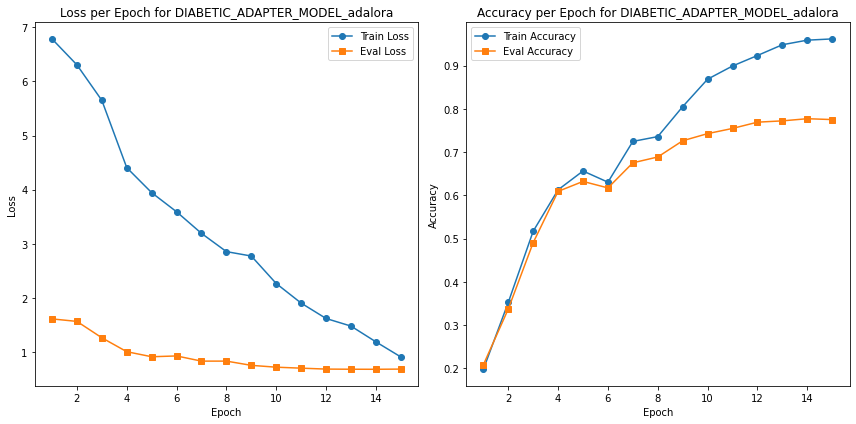

{'eval_loss': 0.6835380792617798, 'eval_accuracy': 0.777, 'eval_f1': 0.7771438940832238, 'eval_precision': 0.7841698477091086, 'eval_recall': 0.777, 'eval_runtime': 91.3292, 'eval_samples_per_second': 21.899, 'eval_steps_per_second': 0.175, 'epoch': 14.285714285714286}

Training DIABETIC_ADAPTER_MODEL with ia3 type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ia3 Adapter trainable parameters: 82,944/85,885,445 (0.10%)
Number of Training Epochs:  15
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'loss': 6.7655, 'grad_norm': 0.11148657649755478, 'learning_rate': 0.00075, 'epoch': 0.9523809523809523}
{'eval_loss': 1.601464867591858, 'eval_accuracy': 0.235, 'eval_f1': 0.17400330768500666, 'eval_precision': 0.2849471734645586, 'eval_recall': 0.235, 'eval_runtime': 91.5042, 'eval_samples_per_second': 21.857, 'eval_steps_per_second': 0.175, 'epoch': 0.9523809523809523}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'loss': 6.2238, 'grad_norm': 0.12704473733901978, 'learning_rate': 0.00155, 'epoch': 1.9682539682539684}
{'eval_loss': 1.559091329574585, 'eval_accuracy': 0.4065, 'eval_f1': 0.3703583711623113, 'eval_precision': 0.3616219925935021, 'eval_recall': 0.4065, 'eval_runtime': 91.3678, 'eval_samples_per_second': 21.89, 'eval_steps_per_second': 0.175, 'epoch': 1.9682539682539684}
Starting Epoch 3
Epoch 3 ending
Completed Epoch 3
{'loss'

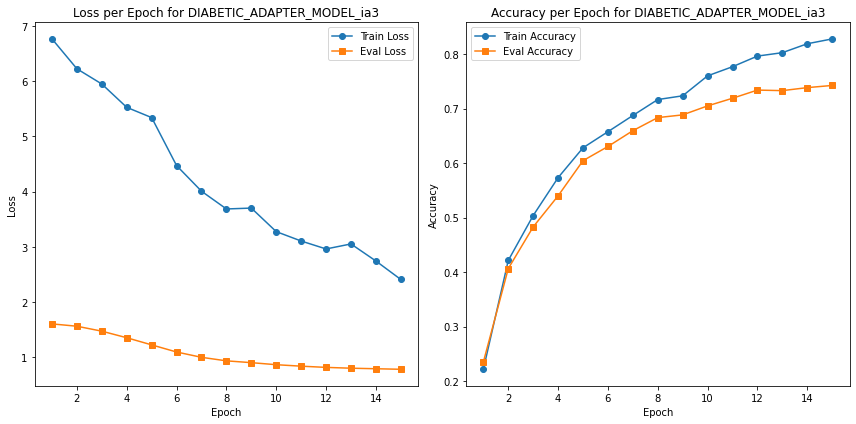

{'eval_loss': 0.778987467288971, 'eval_accuracy': 0.7425, 'eval_f1': 0.7387423385728011, 'eval_precision': 0.7395681667391675, 'eval_recall': 0.7425, 'eval_runtime': 92.07, 'eval_samples_per_second': 21.723, 'eval_steps_per_second': 0.174, 'epoch': 14.285714285714286}

Training DIABETIC_ADAPTER_MODEL with loha type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


loha Adapter trainable parameters: 884,736/86,687,237 (1.02%)
Number of Training Epochs:  15
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'loss': 6.7769, 'grad_norm': 0.020843159407377243, 'learning_rate': 0.00075, 'epoch': 0.9523809523809523}
{'eval_loss': 1.6085820198059082, 'eval_accuracy': 0.2225, 'eval_f1': 0.15836180211267215, 'eval_precision': 0.22981125281830522, 'eval_recall': 0.2225, 'eval_runtime': 91.4558, 'eval_samples_per_second': 21.868, 'eval_steps_per_second': 0.175, 'epoch': 0.9523809523809523}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'loss': 6.2416, 'grad_norm': 0.06682288646697998, 'learning_rate': 0.00155, 'epoch': 1.9682539682539684}
{'eval_loss': 1.5429506301879883, 'eval_accuracy': 0.4165, 'eval_f1': 0.3707110053739441, 'eval_precision': 0.3850063000972548, 'eval_recall': 0.4165, 'eval_runtime': 91.3665, 'eval_samples_per_second': 21.89, 'eval_steps_per_second': 0.175, 'epoch': 1.9682539682539684}
Starting Epoch 3
Epoch 3 ending
Completed Epoch 3

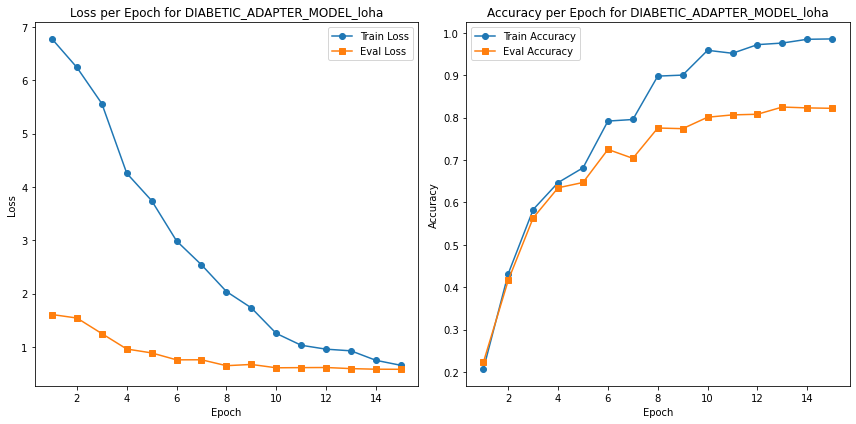

{'eval_loss': 0.5945740938186646, 'eval_accuracy': 0.825, 'eval_f1': 0.8230472321880916, 'eval_precision': 0.8269392179141071, 'eval_recall': 0.825, 'eval_runtime': 91.4979, 'eval_samples_per_second': 21.858, 'eval_steps_per_second': 0.175, 'epoch': 14.285714285714286}

Training DIABETIC_ADAPTER_MODEL with lokr type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


lokr Adapter trainable parameters: 39,168/85,841,669 (0.05%)
Number of Training Epochs:  15
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'loss': 6.7652, 'grad_norm': 0.03197351470589638, 'learning_rate': 0.00075, 'epoch': 0.9523809523809523}
{'eval_loss': 1.611269474029541, 'eval_accuracy': 0.245, 'eval_f1': 0.1835521032013757, 'eval_precision': 0.2047401490188523, 'eval_recall': 0.245, 'eval_runtime': 92.837, 'eval_samples_per_second': 21.543, 'eval_steps_per_second': 0.172, 'epoch': 0.9523809523809523}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'loss': 6.3135, 'grad_norm': 0.047955967485904694, 'learning_rate': 0.00155, 'epoch': 1.9682539682539684}
{'eval_loss': 1.596902847290039, 'eval_accuracy': 0.3215, 'eval_f1': 0.23833965454000486, 'eval_precision': 0.2580566071238889, 'eval_recall': 0.3215, 'eval_runtime': 92.7027, 'eval_samples_per_second': 21.574, 'eval_steps_per_second': 0.173, 'epoch': 1.9682539682539684}
Starting Epoch 3
Epoch 3 ending
Completed Epoch 3
{'los

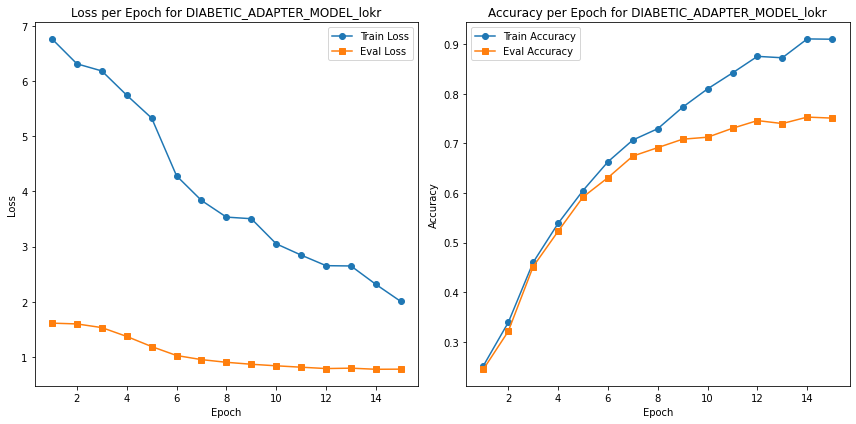

{'eval_loss': 0.7745146751403809, 'eval_accuracy': 0.753, 'eval_f1': 0.7495251130089022, 'eval_precision': 0.7547592835659592, 'eval_recall': 0.753, 'eval_runtime': 92.5287, 'eval_samples_per_second': 21.615, 'eval_steps_per_second': 0.173, 'epoch': 14.285714285714286}

Training SKIN_CANCER_ADAPTER_MODEL with lora type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


lora Adapter trainable parameters: 221,184/86,026,761 (0.26%)
Number of Training Epochs:  15
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'loss': 8.4229, 'grad_norm': 2.0308446884155273, 'learning_rate': 0.0014000000000000002, 'epoch': 0.9911504424778761}
{'eval_loss': 1.7393622398376465, 'eval_accuracy': 0.42, 'eval_f1': 0.3736455159820908, 'eval_precision': 0.49389117694355034, 'eval_recall': 0.42, 'eval_runtime': 51.5869, 'eval_samples_per_second': 69.785, 'eval_steps_per_second': 0.562, 'epoch': 0.9911504424778761}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'loss': 5.7279, 'grad_norm': 5.120905876159668, 'learning_rate': 0.0028000000000000004, 'epoch': 1.9823008849557522}
{'eval_loss': 1.1731613874435425, 'eval_accuracy': 0.6466666666666666, 'eval_f1': 0.6048927508086855, 'eval_precision': 0.6464380486539828, 'eval_recall': 0.6466666666666666, 'eval_runtime': 50.6731, 'eval_samples_per_second': 71.044, 'eval_steps_per_second': 0.572, 'epoch': 1.9823008849557522}
Start

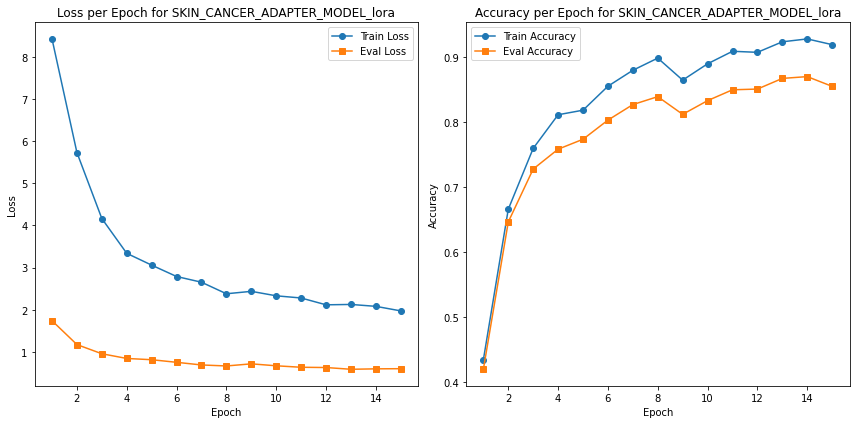

{'eval_loss': 0.5976763367652893, 'eval_accuracy': 0.8702777777777778, 'eval_f1': 0.8689326880056805, 'eval_precision': 0.8738909123398945, 'eval_recall': 0.8702777777777778, 'eval_runtime': 51.0153, 'eval_samples_per_second': 70.567, 'eval_steps_per_second': 0.568, 'epoch': 14.867256637168142}

Training SKIN_CANCER_ADAPTER_MODEL with adalora type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


adalora Adapter trainable parameters: 442,656/86,248,269 (0.51%)
Number of Training Epochs:  15
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'loss': 8.874, 'grad_norm': 0.23136654496192932, 'learning_rate': 0.0014000000000000002, 'epoch': 0.9911504424778761}
{'eval_loss': 2.1836190223693848, 'eval_accuracy': 0.16361111111111112, 'eval_f1': 0.1415201899910586, 'eval_precision': 0.17981662746732385, 'eval_recall': 0.16361111111111112, 'eval_runtime': 50.6389, 'eval_samples_per_second': 71.092, 'eval_steps_per_second': 0.573, 'epoch': 0.9911504424778761}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'loss': 7.9307, 'grad_norm': 0.6403779983520508, 'learning_rate': 0.0028000000000000004, 'epoch': 1.9823008849557522}
{'eval_loss': 1.6411662101745605, 'eval_accuracy': 0.4613888888888889, 'eval_f1': 0.40798200164943976, 'eval_precision': 0.41400213509847883, 'eval_recall': 0.4613888888888889, 'eval_runtime': 50.2049, 'eval_samples_per_second': 71.706, 'eval_steps_per_second': 0.578

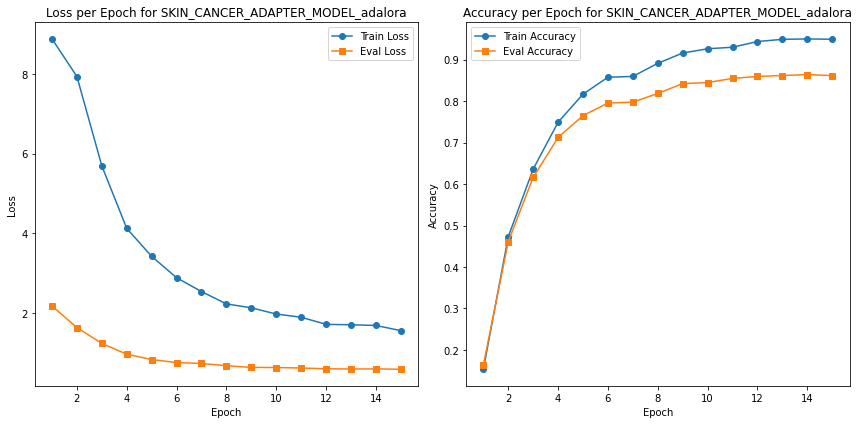

{'eval_loss': 0.6072123646736145, 'eval_accuracy': 0.8638888888888889, 'eval_f1': 0.8630184245189677, 'eval_precision': 0.8707879468130348, 'eval_recall': 0.8638888888888889, 'eval_runtime': 50.4635, 'eval_samples_per_second': 71.339, 'eval_steps_per_second': 0.575, 'epoch': 14.867256637168142}

Training SKIN_CANCER_ADAPTER_MODEL with ia3 type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ia3 Adapter trainable parameters: 82,944/85,888,521 (0.10%)
Number of Training Epochs:  15
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'loss': 8.8402, 'grad_norm': 0.09127966314554214, 'learning_rate': 0.0014000000000000002, 'epoch': 0.9911504424778761}
{'eval_loss': 2.167861223220825, 'eval_accuracy': 0.19944444444444445, 'eval_f1': 0.17938022992772137, 'eval_precision': 0.24676327267649992, 'eval_recall': 0.19944444444444445, 'eval_runtime': 50.7229, 'eval_samples_per_second': 70.974, 'eval_steps_per_second': 0.572, 'epoch': 0.9911504424778761}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'loss': 8.5353, 'grad_norm': 0.11974034458398819, 'learning_rate': 0.0028000000000000004, 'epoch': 1.9823008849557522}
{'eval_loss': 2.0426828861236572, 'eval_accuracy': 0.44, 'eval_f1': 0.42488913176745313, 'eval_precision': 0.4591887711793009, 'eval_recall': 0.44, 'eval_runtime': 50.6743, 'eval_samples_per_second': 71.042, 'eval_steps_per_second': 0.572, 'epoch': 1.9823008849557522}
S

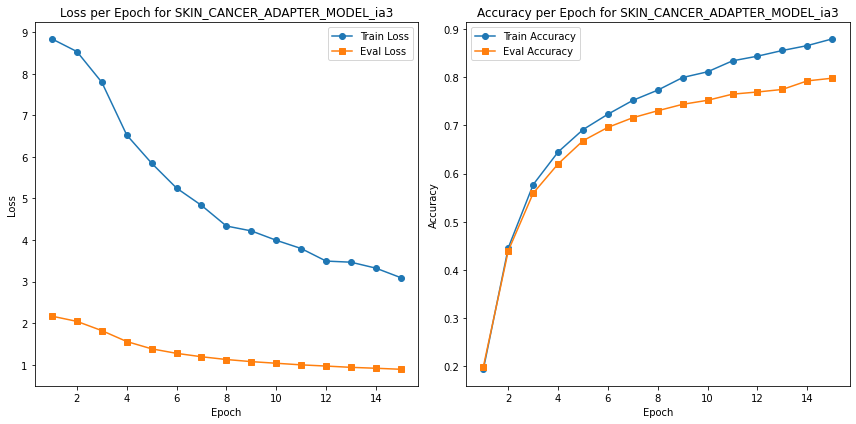

{'eval_loss': 0.8898079991340637, 'eval_accuracy': 0.7980555555555555, 'eval_f1': 0.7901155551510375, 'eval_precision': 0.8032013745716327, 'eval_recall': 0.7980555555555555, 'eval_runtime': 50.6891, 'eval_samples_per_second': 71.021, 'eval_steps_per_second': 0.572, 'epoch': 14.867256637168142}

Training SKIN_CANCER_ADAPTER_MODEL with loha type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


loha Adapter trainable parameters: 884,736/86,690,313 (1.02%)
Number of Training Epochs:  15
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'loss': 8.856, 'grad_norm': 0.035272084176540375, 'learning_rate': 0.0014000000000000002, 'epoch': 0.9911504424778761}
{'eval_loss': 2.1690332889556885, 'eval_accuracy': 0.1925, 'eval_f1': 0.17572625011180226, 'eval_precision': 0.23719943702423585, 'eval_recall': 0.1925, 'eval_runtime': 50.3009, 'eval_samples_per_second': 71.569, 'eval_steps_per_second': 0.577, 'epoch': 0.9911504424778761}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'loss': 7.9008, 'grad_norm': 0.18712396919727325, 'learning_rate': 0.0028000000000000004, 'epoch': 1.9823008849557522}
{'eval_loss': 1.6259275674819946, 'eval_accuracy': 0.5102777777777778, 'eval_f1': 0.4667155170422989, 'eval_precision': 0.5448211242673053, 'eval_recall': 0.5102777777777778, 'eval_runtime': 50.5485, 'eval_samples_per_second': 71.219, 'eval_steps_per_second': 0.574, 'epoch': 1.982300884955752

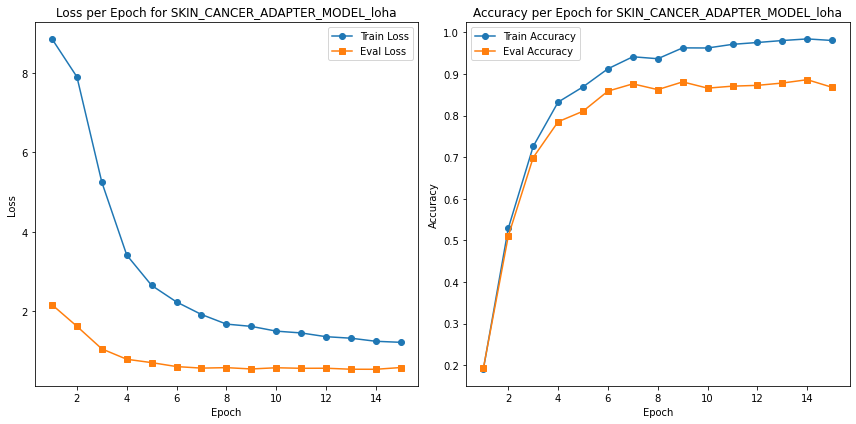

{'eval_loss': 0.5448014736175537, 'eval_accuracy': 0.8863888888888889, 'eval_f1': 0.8868506213097822, 'eval_precision': 0.8894276316884945, 'eval_recall': 0.8863888888888889, 'eval_runtime': 50.8875, 'eval_samples_per_second': 70.744, 'eval_steps_per_second': 0.57, 'epoch': 14.867256637168142}

Training SKIN_CANCER_ADAPTER_MODEL with lokr type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


lokr Adapter trainable parameters: 39,168/85,844,745 (0.05%)
Number of Training Epochs:  15
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'loss': 8.8811, 'grad_norm': 0.034247275441884995, 'learning_rate': 0.0014000000000000002, 'epoch': 0.9911504424778761}
{'eval_loss': 2.194472551345825, 'eval_accuracy': 0.10138888888888889, 'eval_f1': 0.07214387816158858, 'eval_precision': 0.10321381196575358, 'eval_recall': 0.10138888888888889, 'eval_runtime': 50.8841, 'eval_samples_per_second': 70.749, 'eval_steps_per_second': 0.57, 'epoch': 0.9911504424778761}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'loss': 8.7458, 'grad_norm': 0.10421907901763916, 'learning_rate': 0.0028000000000000004, 'epoch': 1.9823008849557522}
{'eval_loss': 2.1125335693359375, 'eval_accuracy': 0.275, 'eval_f1': 0.24417177128818482, 'eval_precision': 0.3886317300605823, 'eval_recall': 0.275, 'eval_runtime': 50.8804, 'eval_samples_per_second': 70.754, 'eval_steps_per_second': 0.57, 'epoch': 1.9823008849557522}

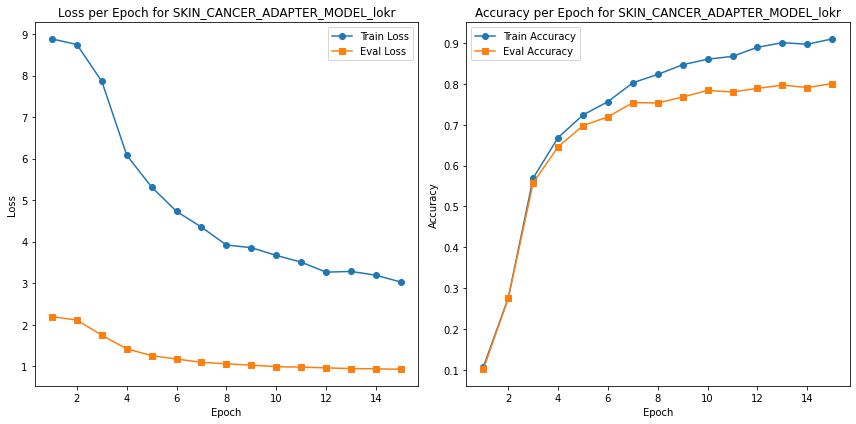

{'eval_loss': 0.9277461767196655, 'eval_accuracy': 0.8005555555555556, 'eval_f1': 0.8004926784697243, 'eval_precision': 0.8058465490390813, 'eval_recall': 0.8005555555555556, 'eval_runtime': 52.4235, 'eval_samples_per_second': 68.672, 'eval_steps_per_second': 0.553, 'epoch': 14.867256637168142}

Training KIDNEY_ADAPTER_MODEL with lora type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


lora Adapter trainable parameters: 221,184/86,022,916 (0.26%)
Number of Training Epochs:  15
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'loss': 5.6501, 'grad_norm': 0.2944377660751343, 'learning_rate': 0.00045, 'epoch': 0.972972972972973}
{'eval_loss': 1.3599072694778442, 'eval_accuracy': 0.3877551020408163, 'eval_f1': 0.3726220082063631, 'eval_precision': 0.37500838327864183, 'eval_recall': 0.3877551020408163, 'eval_runtime': 23.0897, 'eval_samples_per_second': 50.932, 'eval_steps_per_second': 0.433, 'epoch': 0.972972972972973}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'loss': 5.4697, 'grad_norm': 1.3892959356307983, 'learning_rate': 0.0009, 'epoch': 1.945945945945946}
{'eval_loss': 1.2861677408218384, 'eval_accuracy': 0.5595238095238095, 'eval_f1': 0.5514906871864724, 'eval_precision': 0.5836396646481025, 'eval_recall': 0.5595238095238095, 'eval_runtime': 19.8668, 'eval_samples_per_second': 59.194, 'eval_steps_per_second': 0.503, 'epoch': 1.945945945945946}
Starting 

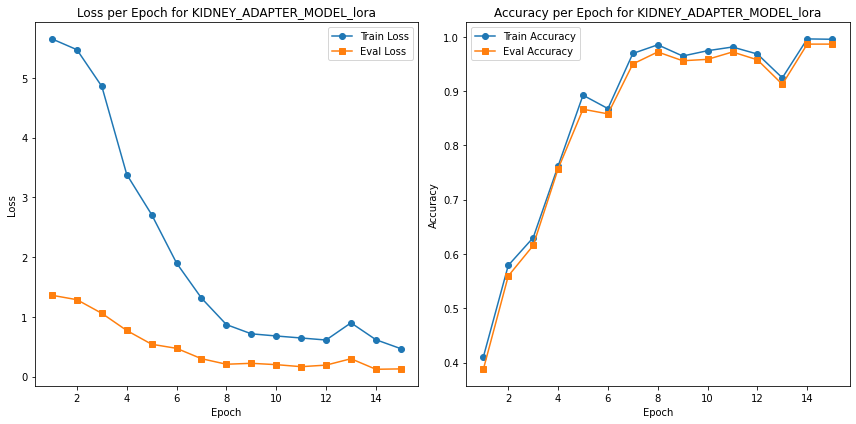

{'eval_loss': 0.12165842950344086, 'eval_accuracy': 0.9863945578231292, 'eval_f1': 0.9864134100285927, 'eval_precision': 0.9865277353803479, 'eval_recall': 0.9863945578231292, 'eval_runtime': 19.8491, 'eval_samples_per_second': 59.247, 'eval_steps_per_second': 0.504, 'epoch': 14.594594594594595}

Training KIDNEY_ADAPTER_MODEL with adalora type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


adalora Adapter trainable parameters: 442,656/86,244,424 (0.51%)
Number of Training Epochs:  15
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'loss': 5.7247, 'grad_norm': 0.009442731738090515, 'learning_rate': 0.00045, 'epoch': 0.972972972972973}
{'eval_loss': 1.3932939767837524, 'eval_accuracy': 0.2602040816326531, 'eval_f1': 0.16542557879634404, 'eval_precision': 0.40825014343086635, 'eval_recall': 0.2602040816326531, 'eval_runtime': 20.0962, 'eval_samples_per_second': 58.519, 'eval_steps_per_second': 0.498, 'epoch': 0.972972972972973}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'loss': 5.7223, 'grad_norm': 0.07613242417573929, 'learning_rate': 0.0009, 'epoch': 1.945945945945946}
{'eval_loss': 1.3909273147583008, 'eval_accuracy': 0.26785714285714285, 'eval_f1': 0.17359471755554068, 'eval_precision': 0.4150053887900413, 'eval_recall': 0.26785714285714285, 'eval_runtime': 19.6412, 'eval_samples_per_second': 59.874, 'eval_steps_per_second': 0.509, 'epoch': 1.945945945945946}

Could not locate the best model at ./model-checkpoints/checkpoint-111/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


{'train_runtime': 2708.9911, 'train_samples_per_second': 26.03, 'train_steps_per_second': 0.05, 'train_loss': 3.028380083154749, 'epoch': 14.594594594594595}

Training completed for KIDNEY_ADAPTER_MODEL_adalora. Final Metrics:
+----+---------+------------------+-----------------+--------------+-------------+----------+-------------+----------+
|    |   Epoch |   Train Accuracy |   Eval Accuracy |   Train Loss |   Eval Loss |       F1 |   Precision |   Recall |
+====+=========+==================+=================+==============+=============+==========+=============+==========+
|  0 |       1 |         0.273559 |        0.260204 |       5.7247 |    1.39329  | 0.165426 |    0.40825  | 0.260204 |
+----+---------+------------------+-----------------+--------------+-------------+----------+-------------+----------+
|  1 |       2 |         0.278026 |        0.267857 |       5.7223 |    1.39093  | 0.173595 |    0.415005 | 0.267857 |
+----+---------+------------------+-----------------+------

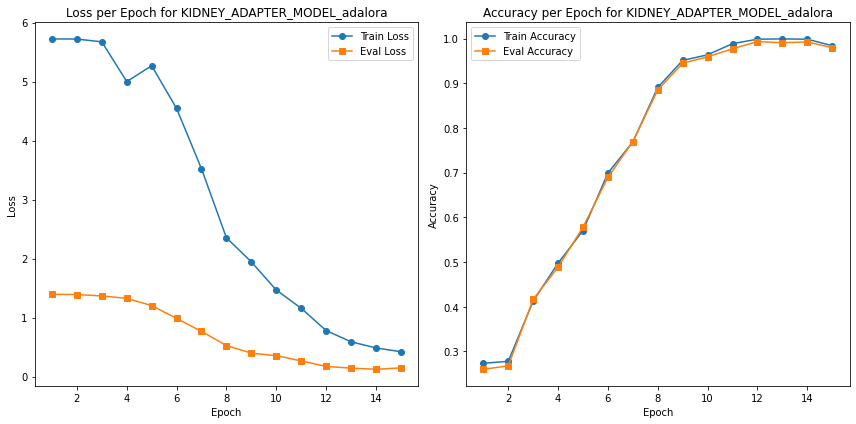

{'eval_loss': 0.1468484103679657, 'eval_accuracy': 0.9795918367346939, 'eval_f1': 0.9794257919457343, 'eval_precision': 0.9807000566782348, 'eval_recall': 0.9795918367346939, 'eval_runtime': 19.7882, 'eval_samples_per_second': 59.429, 'eval_steps_per_second': 0.505, 'epoch': 14.594594594594595}

Training KIDNEY_ADAPTER_MODEL with ia3 type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ia3 Adapter trainable parameters: 82,944/85,884,676 (0.10%)
Number of Training Epochs:  15
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'loss': 5.7174, 'grad_norm': 0.13565625250339508, 'learning_rate': 0.00045, 'epoch': 0.972972972972973}
{'eval_loss': 1.3862719535827637, 'eval_accuracy': 0.28316326530612246, 'eval_f1': 0.1878433886359242, 'eval_precision': 0.42480590067853935, 'eval_recall': 0.28316326530612246, 'eval_runtime': 19.8701, 'eval_samples_per_second': 59.185, 'eval_steps_per_second': 0.503, 'epoch': 0.972972972972973}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'loss': 5.6579, 'grad_norm': 0.10046500712633133, 'learning_rate': 0.0009, 'epoch': 1.945945945945946}
{'eval_loss': 1.3665539026260376, 'eval_accuracy': 0.3554421768707483, 'eval_f1': 0.26471796345058846, 'eval_precision': 0.5177993287120038, 'eval_recall': 0.3554421768707483, 'eval_runtime': 19.841, 'eval_samples_per_second': 59.271, 'eval_steps_per_second': 0.504, 'epoch': 1.945945945945946}
Startin

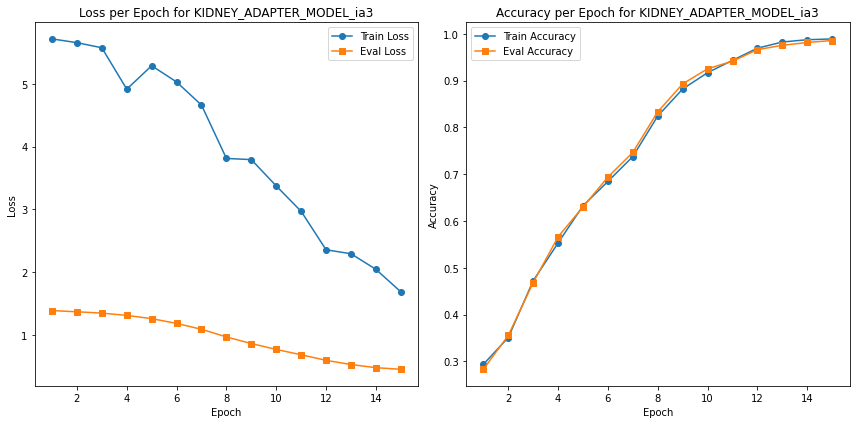

{'eval_loss': 0.4500739574432373, 'eval_accuracy': 0.9855442176870748, 'eval_f1': 0.9855413435708836, 'eval_precision': 0.9856454060528574, 'eval_recall': 0.9855442176870748, 'eval_runtime': 19.9567, 'eval_samples_per_second': 58.928, 'eval_steps_per_second': 0.501, 'epoch': 14.594594594594595}

Training KIDNEY_ADAPTER_MODEL with loha type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


loha Adapter trainable parameters: 884,736/86,686,468 (1.02%)
Number of Training Epochs:  15
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'loss': 5.7225, 'grad_norm': 0.02266189269721508, 'learning_rate': 0.00045, 'epoch': 0.972972972972973}
{'eval_loss': 1.3910900354385376, 'eval_accuracy': 0.26785714285714285, 'eval_f1': 0.17344496397199138, 'eval_precision': 0.4143238672474615, 'eval_recall': 0.26785714285714285, 'eval_runtime': 19.8123, 'eval_samples_per_second': 59.357, 'eval_steps_per_second': 0.505, 'epoch': 0.972972972972973}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'loss': 5.6968, 'grad_norm': 0.028874080628156662, 'learning_rate': 0.0009, 'epoch': 1.945945945945946}
{'eval_loss': 1.3784171342849731, 'eval_accuracy': 0.30357142857142855, 'eval_f1': 0.20482900397840306, 'eval_precision': 0.4385042324397543, 'eval_recall': 0.30357142857142855, 'eval_runtime': 20.0466, 'eval_samples_per_second': 58.663, 'eval_steps_per_second': 0.499, 'epoch': 1.945945945945946}
S

Could not locate the best model at ./model-checkpoints/checkpoint-120/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


{'train_runtime': 2710.946, 'train_samples_per_second': 26.011, 'train_steps_per_second': 0.05, 'train_loss': 2.7463500835277417, 'epoch': 14.594594594594595}

Training completed for KIDNEY_ADAPTER_MODEL_loha. Final Metrics:
+----+---------+------------------+-----------------+--------------+-------------+----------+-------------+----------+
|    |   Epoch |   Train Accuracy |   Eval Accuracy |   Train Loss |   Eval Loss |       F1 |   Precision |   Recall |
+====+=========+==================+=================+==============+=============+==========+=============+==========+
|  0 |       1 |         0.278026 |        0.267857 |       5.7225 |    1.39109  | 0.173445 |    0.414324 | 0.267857 |
+----+---------+------------------+-----------------+--------------+-------------+----------+-------------+----------+
|  1 |       2 |         0.310359 |        0.303571 |       5.6968 |    1.37842  | 0.204829 |    0.438504 | 0.303571 |
+----+---------+------------------+-----------------+--------

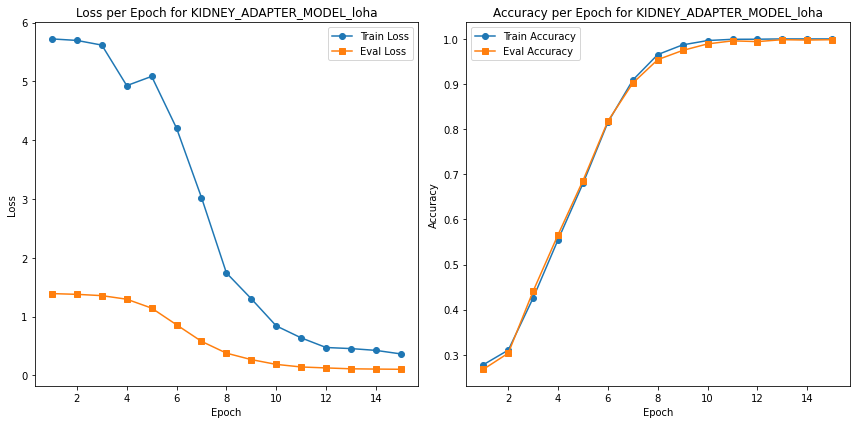

{'eval_loss': 0.10384950041770935, 'eval_accuracy': 0.9982993197278912, 'eval_f1': 0.9983012025684271, 'eval_precision': 0.9983123020200446, 'eval_recall': 0.9982993197278912, 'eval_runtime': 20.0713, 'eval_samples_per_second': 58.591, 'eval_steps_per_second': 0.498, 'epoch': 14.594594594594595}

Training KIDNEY_ADAPTER_MODEL with lokr type...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


lokr Adapter trainable parameters: 39,168/85,840,900 (0.05%)
Number of Training Epochs:  15
Starting Epoch 1
Epoch 1 ending
Completed Epoch 1
{'loss': 5.6877, 'grad_norm': 0.03577309846878052, 'learning_rate': 0.00045, 'epoch': 0.972972972972973}
{'eval_loss': 1.3813459873199463, 'eval_accuracy': 0.266156462585034, 'eval_f1': 0.2399370231954009, 'eval_precision': 0.27836337866202665, 'eval_recall': 0.266156462585034, 'eval_runtime': 19.9218, 'eval_samples_per_second': 59.031, 'eval_steps_per_second': 0.502, 'epoch': 0.972972972972973}
Starting Epoch 2
Epoch 2 ending
Completed Epoch 2
{'loss': 5.6778, 'grad_norm': 0.0416555292904377, 'learning_rate': 0.0009, 'epoch': 1.945945945945946}
{'eval_loss': 1.3772753477096558, 'eval_accuracy': 0.288265306122449, 'eval_f1': 0.2733787260228138, 'eval_precision': 0.3096484757295363, 'eval_recall': 0.288265306122449, 'eval_runtime': 19.8843, 'eval_samples_per_second': 59.142, 'eval_steps_per_second': 0.503, 'epoch': 1.945945945945946}
Starting Epoc

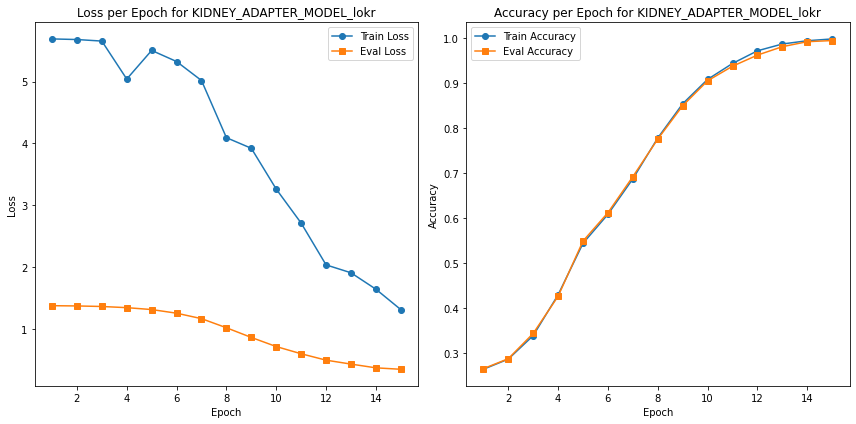

{'eval_loss': 0.3548600673675537, 'eval_accuracy': 0.9940476190476191, 'eval_f1': 0.9940534285554169, 'eval_precision': 0.9940701446141369, 'eval_recall': 0.9940476190476191, 'eval_runtime': 20.0777, 'eval_samples_per_second': 58.573, 'eval_steps_per_second': 0.498, 'epoch': 14.594594594594595}


In [30]:
results = {}
for adapter_type in config_medX.keys():
    for lora_type in adapter_configs.keys():
        print(f"\nTraining {adapter_type} with {lora_type} type...")
        metrics = train_model_with_adapter(adapter_type, lora_type)
        results[f"{adapter_type}_{lora_type}"] = metrics

In [31]:
def display_results_as_table(results):
    '''
    Displays a comparison table of evaluation metrics for each adapter and LoRA configuration
    by creating a DataFrame from the results and printing it.
    '''
    rows = []
    for model_adapter, metrics in results.items():
        adapter_type, lora_type = model_adapter.split("_", 1)
        row = {
            "Adapter": adapter_type,
            "LoRA Type": lora_type,
            "Eval Loss": metrics.get("eval_loss", None),
            "Eval Accuracy": metrics.get("eval_accuracy", None),
            "Eval F1": metrics.get("eval_f1", None),
            "Eval Precision": metrics.get("eval_precision", None),
            "Eval Recall": metrics.get("eval_recall", None),
            "Epoch": metrics.get("epoch", None)
        }
        rows.append(row)
    df = pd.DataFrame(rows)
    df = df.sort_values(by=["Adapter", "LoRA Type"])
    print("\n=== Comparison of All Adapter and LoRA Models ===")
    print(df.to_string(index=False))

display_results_as_table(results)


=== Comparison of All Adapter and LoRA Models ===
 Adapter                    LoRA Type  Eval Loss  Eval Accuracy  Eval F1  Eval Precision  Eval Recall     Epoch
DIABETIC        ADAPTER_MODEL_adalora   0.683538       0.777000 0.777144        0.784170     0.777000 14.285714
DIABETIC            ADAPTER_MODEL_ia3   0.778987       0.742500 0.738742        0.739568     0.742500 14.285714
DIABETIC           ADAPTER_MODEL_loha   0.594574       0.825000 0.823047        0.826939     0.825000 14.285714
DIABETIC           ADAPTER_MODEL_lokr   0.774515       0.753000 0.749525        0.754759     0.753000 14.285714
DIABETIC           ADAPTER_MODEL_lora   0.589782       0.796500 0.791813        0.794944     0.796500 14.285714
  KIDNEY        ADAPTER_MODEL_adalora   0.146848       0.979592 0.979426        0.980700     0.979592 14.594595
  KIDNEY            ADAPTER_MODEL_ia3   0.450074       0.985544 0.985541        0.985645     0.985544 14.594595
  KIDNEY           ADAPTER_MODEL_loha   0.103850     

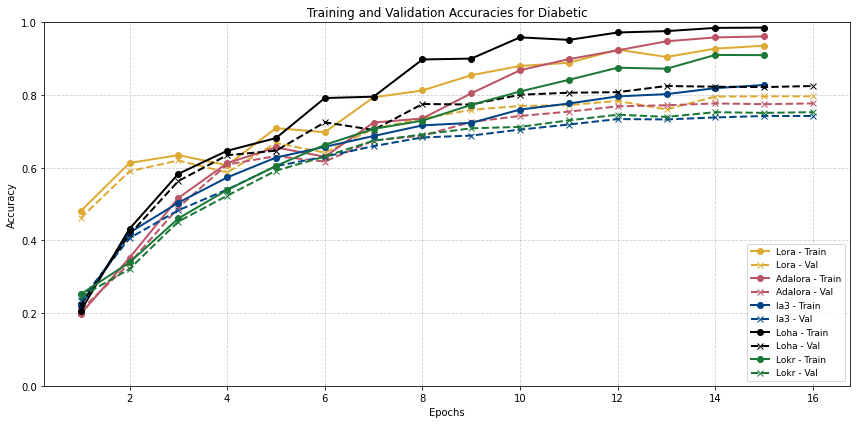

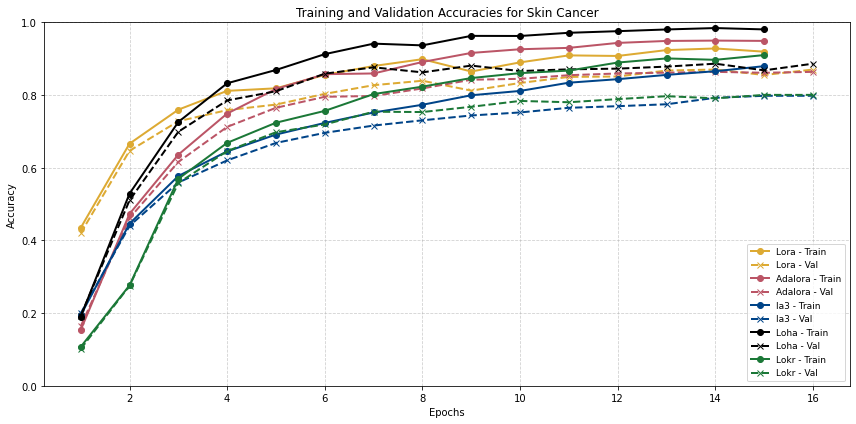

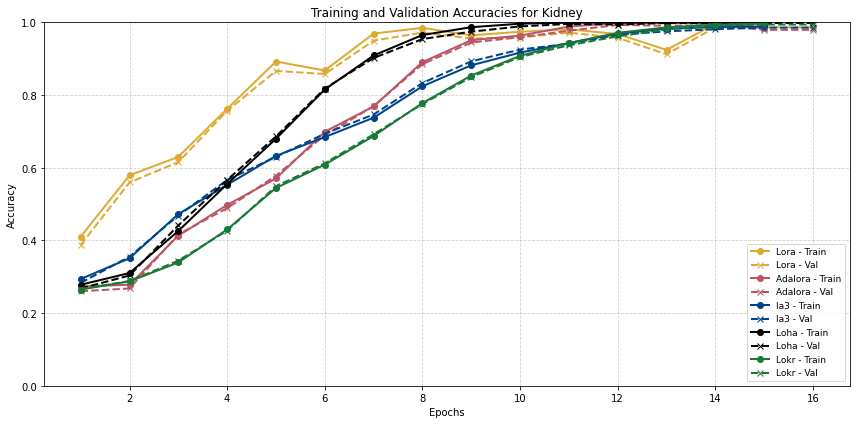

In [32]:
colors = ['#DDAA33', '#BB5566', '#004488', '#000000', '#1B7837', '#117733', '#88CCEE']
def plot_accuracies_per_epoch(metrics_storage):
    '''
    Plots training and validation accuracies per epoch for each adapter configuration.
    Each line represents a different LoRA type within that adapter.
    '''
    max_epochs = max(
        max(len(metrics.get('train_accuracy', [])), len(metrics.get('eval_accuracy', [])))
        for lora_metrics in metrics_storage.values() for metrics in lora_metrics.values()
    )
    for adapter_name, lora_metrics in metrics_storage.items():
        fig, ax = plt.subplots(figsize=(12, 6))
        for i, (lora_type, metrics) in enumerate(lora_metrics.items()):
            train_accuracies = metrics.get('train_accuracy', [])
            val_accuracies = metrics.get('eval_accuracy', [])
            train_accuracies = np.array(train_accuracies + [np.nan] * (max_epochs - len(train_accuracies)))
            val_accuracies = np.array(val_accuracies + [np.nan] * (max_epochs - len(val_accuracies)))
            epochs = np.arange(1, max_epochs + 1)
            ax.plot(epochs, train_accuracies, marker='o', linestyle='-', 
                    label=f'{lora_type.capitalize()} - Train', 
                    color=colors[i % len(colors)], linewidth=2)
            ax.plot(epochs, val_accuracies, marker='x', linestyle='--', 
                    label=f'{lora_type.capitalize()} - Val', 
                    color=colors[i % len(colors)], linewidth=2)
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Accuracy')
        ax.set_ylim(0, 1)
        ax.set_title(f'Training and Validation Accuracies for {adapter_name.replace("_ADAPTER_MODEL", "").replace("_", " ").title()}')
        ax.legend(loc='lower right', fontsize=9)
        ax.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()
plot_accuracies_per_epoch(metrics_storage)
